# **BikeML**

# **Predicting the popularity of Bike Sharing using time-series data.**

**Introduction: This ML Project will make use of [UCI's Bike Sharing Dataset](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset) to perform analysis, gather insights and make predictions regarding the usage of Bike Sharing**

## Chapter 1: Problem
For the first time ever, Singapore's population has risen over 6 million (cite) in 2023. Rooted in this phenomenon are the pains of overcrowding, overpopulation and general inconvenience when traveling from one point to another.

In NUS, it is a common sight to see the Internal Shuttle Buses (ISBs) completely packed full of students with little room to stand. Often times, the doors of the bus are unable to close due to students at the doorstep triggering the motion sensor.

A couple of years ago, a solution in the form of Bike Sharing/Bike Renting had appeared, with companies such as OFO or Mobike aggressively providing Bike Sharing options to alleviate Singaporeans' transport woes. However, they have since vanished, with large numbers of Bikes being destroyed, resulting in waste and pollution (Cite) as a result.

I believe that this was due to inefficient allocation of bikes, and the inability to bring Bike Sharing to an area where the population really needs it, compared to making bikes abundantly available throughout Singapore. By intelligently predicting demand and thus allocating bikes to areas of high human traffic, bike vendors can minimize waste of resources, and at the same time alleviate the problem of packed peak periods by providing alternate short distance biking options.

### Chapter 1.1: Solution

The proposed Machine Learning Solution makes use of existing data on the demand of bike-sharing programs, measured together with attributes such as temperature, humidity, time etc. By fitting a Machine Learning model using this data, users (Bike Vendors) can then make use of their very own ground conditions to accurately predict the volume of demand at that specific point of time, thus helping them implement bike-sharing strategies.

## Chapter 2: Data

As per any Machine Learning Projects, we need to obtain, clean and visualise our existing data. The given Dataset is the UCI Bike Sharing Dataset, and contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. It can be found [here](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset).

### Chapter 2.1: Import Libraries

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy import mean
from numpy import std

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import seaborn as sns
from scipy.stats import zscore

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error

In [14]:
# Only to be used if working from Google Colaboratory
# from google.colab import drive
# drive.mount('/content/drive')

Since we are want to predict hourly demand of Bikes, we shall work with `hour.csv` instead of `day.csv`.

In [15]:
import os
os.getcwd()

'/Users/alvin/Documents/GitHub/BikeML'

In [16]:
FILEPATH = "dataset/hour.csv"
df = pd.read_csv(FILEPATH)

### Chapter 2.2: Exploratory Data Analysis

Visualise a summary of the raw data.

In [17]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [18]:
df.drop(['instant'], axis = 1, inplace = True)
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.1+ MB


Right of the bat, I noticed some interesting characteristics. Firstly, 'instant' is not necessary, since it merely tells us the data number. We will remove this. Next, dteday is of type Object, which will be challenging for ML. We need to change the data type. The rest of the data looks fine for now.

In [20]:
df["dteday"] = pd.to_datetime(df["dteday"])

Now we check the data for null values. If there are, we need to fill the null values using either mean/median(numerical) or mode(categorical). In this case, we can see that there are no null values.

In [21]:
df.isnull().sum(axis=0)

dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [22]:
# holdout_df = df.loc[df["dteday"] >= '2012-12-02']
# df = df.loc[df["dteday"] < '2012-12-02']

Next, let's start to visualise the data so that we can have a better understanding of what the data looks like. The following shows the trend for the demand for rented bikes over the entire period of 2 years. On the macro scale, it can be observed that there is generally a higher demand in 2012 compared to 2011.

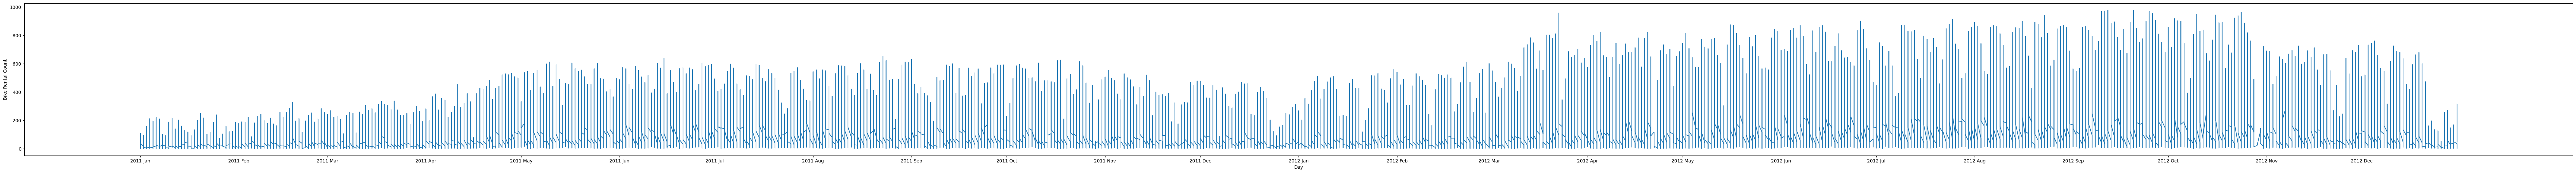

In [23]:
plt.figure(figsize=(100,6))
plt.plot(df['dteday'], df["cnt"])
plt.xticks(["2011-01", "2011-02", "2011-03", "2011-04", "2011-05", "2011-06", "2011-07", "2011-08", "2011-09", "2011-10", "2011-11", "2011-12", "2012-01", "2012-02", "2012-03", "2012-04", "2012-05", "2012-06", "2012-07", "2012-08", "2012-09", "2012-10", "2012-11", "2012-12"],
           ["2011 Jan", "2011 Feb", "2011 Mar", "2011 Apr", "2011 May", "2011 Jun", "2011 Jul", "2011 Aug", "2011 Sep", "2011 Oct", "2011 Nov", "2011 Dec", "2012 Jan", "2012 Feb", "2012 Mar", "2012 Apr", "2012 May", "2012 Jun", "2012 Jul", "2012 Aug", "2012 Sep", "2012 Oct", "2012 Nov", "2012 Dec",])
plt.xlabel('Day')
plt.ylabel("Bike Rental Count")
plt.show()

The following graph shows us what we had expected: During peak periods (7am-9am and 5pm-7pm), the volume of Bike Rentals were higher compared to other non-peak periods.

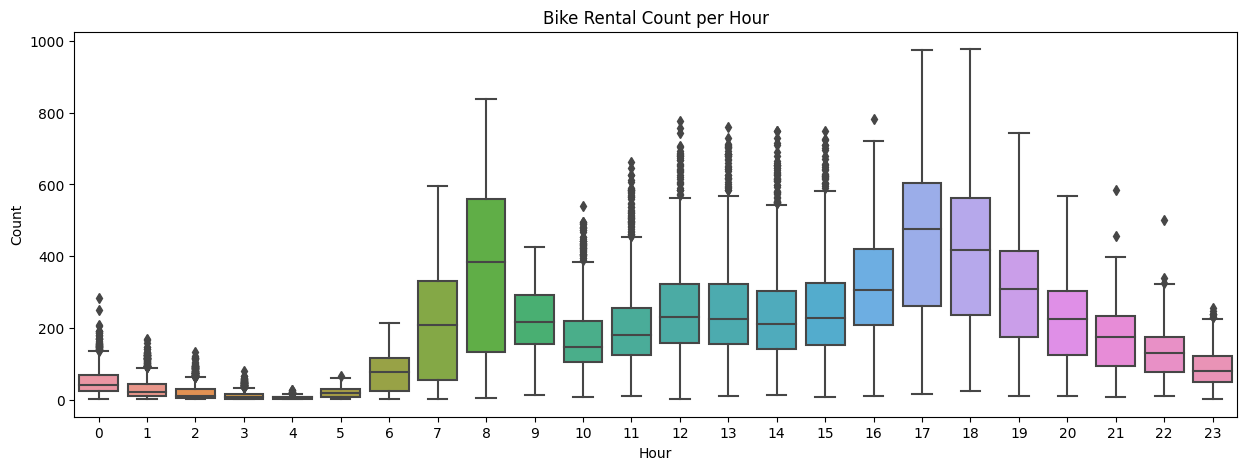

In [24]:
plt.figure(figsize = (15,5))
sns.boxplot(x = 'hr', y = 'cnt', data = df)
plt.title("Bike Rental Count per Hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

Let us now investigate the relationship between temperature and the number of Bike Rentals. In the dataset, the temperature was represented in normalized form. Specifically, $temp = \frac{t-t_{min}}{t_{max} - t_{min}}\,, t_{min} = -8°C\,and\,t_{max} = 39°C$

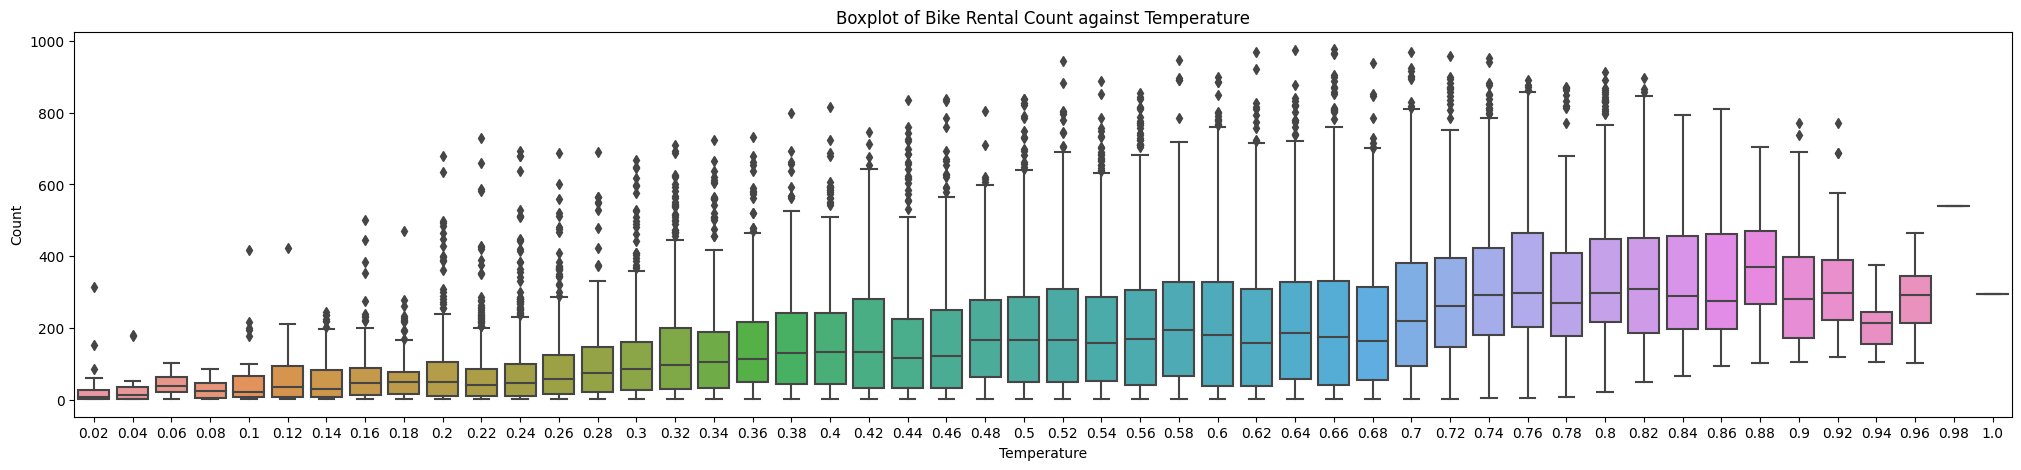

In [25]:
plt.figure(figsize = (25,5))
sns.boxplot(x = 'temp', y = 'cnt', data = df)
plt.title("Boxplot of Bike Rental Count against Temperature")
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.show()

`atemp` is the normalized "feels like" temperature for the same data, and is influenced by an ensemble of factors such as humidity, cloud coverage etc. It is calculated in the same manner as that of `temp`, with a $t_{min} = -16°C \, and \, t_{max} = 50°C.$ Similarly, we can investigate the relationship between this temperature and number of Bike Rentals.

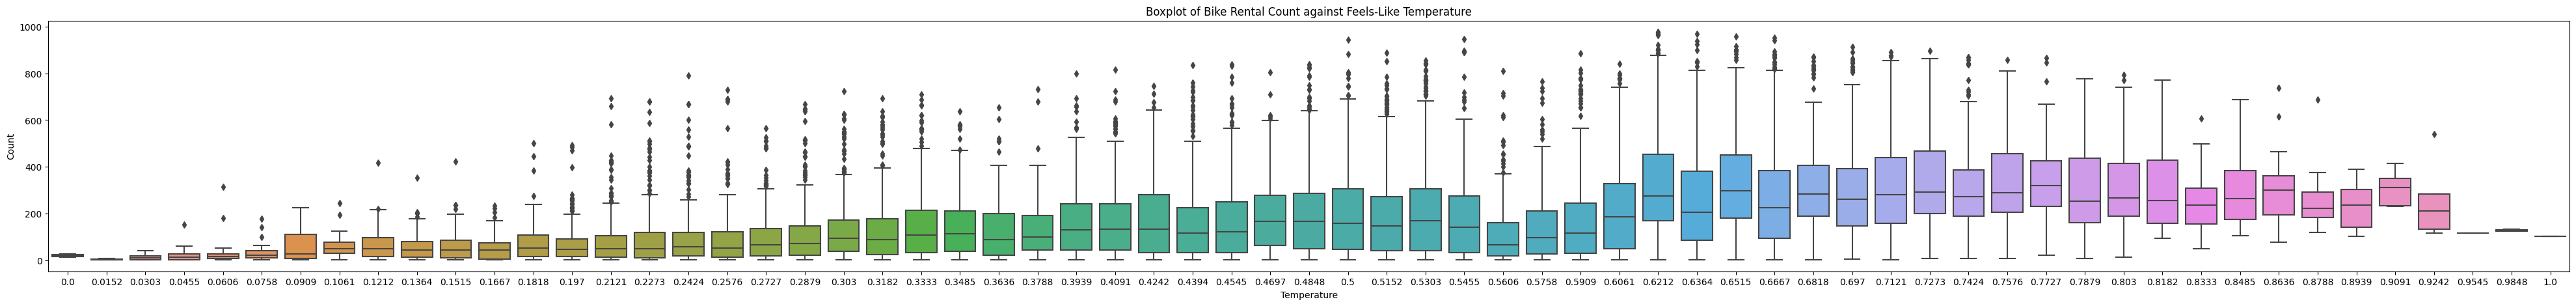

In [26]:
plt.figure(figsize = (50,5))
sns.boxplot(x = 'atemp', y = 'cnt', data = df)
plt.title("Boxplot of Bike Rental Count against Feels-Like Temperature")
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.show()

An additional form of data provided is whether the day in question is a holiday, weekday or weekend. We can investigate how this variable affects the number of Bike Rentals through a bar plot. There is a small spike Bike Rental towards the end of the week but relationship is not prominent.

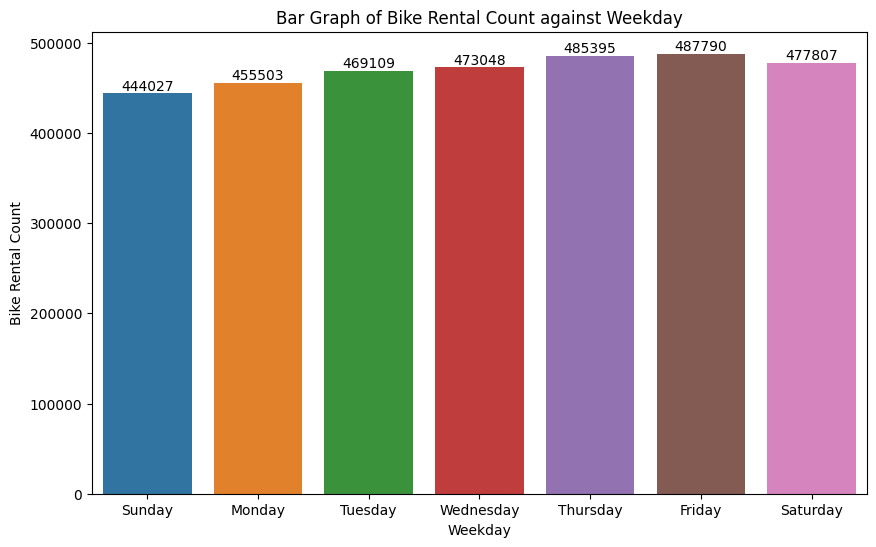

In [27]:
plt.figure(figsize = (10,6))

grouped = df.groupby('weekday')['cnt'].sum().reset_index()

bar_graph = sns.barplot(data=grouped, x="weekday", y="cnt", errorbar = None)
plt.xticks(np.arange(0,7), ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
plt.title("Bar Graph of Bike Rental Count against Weekday")
plt.xlabel("Weekday")
plt.ylabel("Bike Rental Count")

for bar in bar_graph.patches:
    bar_graph.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        round(bar.get_height()),
        ha='center',
        va='bottom'
    )
plt.show()

Next, we investigate the impact of the specific day being a holiday/weekend on the number of Bike Rentals. The pie chart shows that a relatively large proportion of Bike Rentals come from Working Days, however this could be explained by a similar proportion of days that correspond to each type of day.

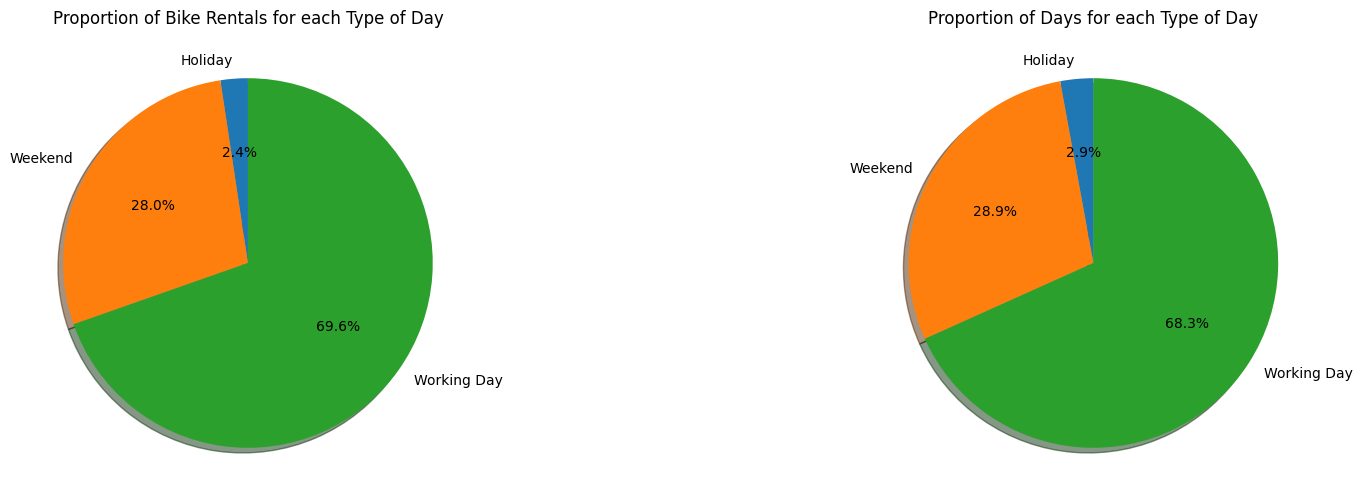

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
# Create a 'type_of_day' column based on the values of 'workingday' and 'holiday'
conditions = [
    (df['workingday'] == 1),
    (df['holiday'] == 1),
    (df['workingday'] == 0) & (df['holiday'] == 0)
]
choices = ['Working Day', 'Holiday', 'Weekend']
df['type_of_day'] = np.select(conditions, choices)
grouped = df.groupby('type_of_day')['cnt'].size()
count_grouped = df.groupby('type_of_day')['cnt'].sum()
ax[0].pie(count_grouped, labels = ['Holiday', 'Weekend', 'Working Day'], autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].set_title('Proportion of Bike Rentals for each Type of Day')
ax[1].pie(grouped, labels = ['Holiday', 'Weekend', 'Working Day'], autopct='%1.1f%%', shadow=True, startangle=90)
ax[1].set_title('Proportion of Days for each Type of Day')
plt.show()

Next, we investigate the relationship between wind speed. There is a noticeable trend where as the windspeed increases, the value and density of Bike Rental decreases.

Text(0, 0.5, 'Bike Rental Count')

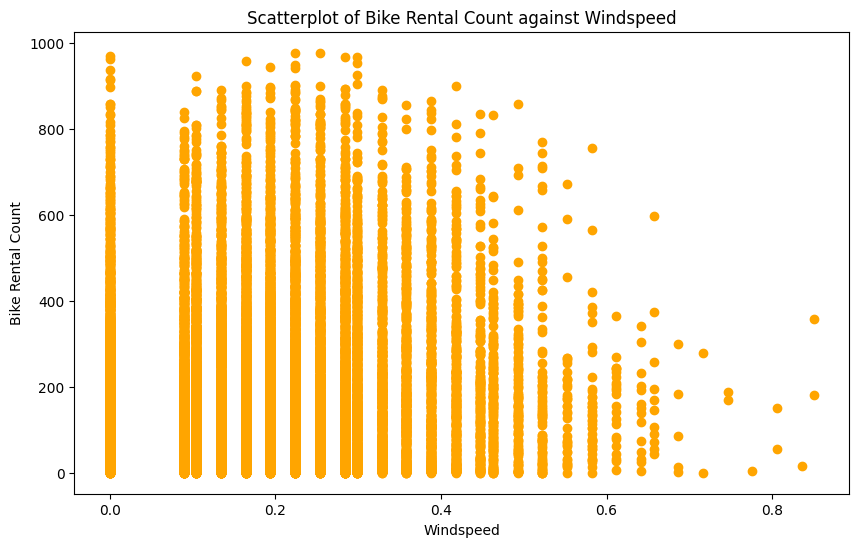

In [29]:
plt.figure(figsize=(10,6))
plt.scatter(df["windspeed"], df["cnt"], color="orange")
plt.title("Scatterplot of Bike Rental Count against Windspeed")
plt.xlabel("Windspeed")
plt.ylabel("Bike Rental Count")

A similar method is used to investigate the relationship between the Number of Bike Rentals and Humidity. We can observe the majority of Bike Rentals seem to cluster around the humidity levels between 0.3 and 0.7, with extremely few between 0 and 0.1.

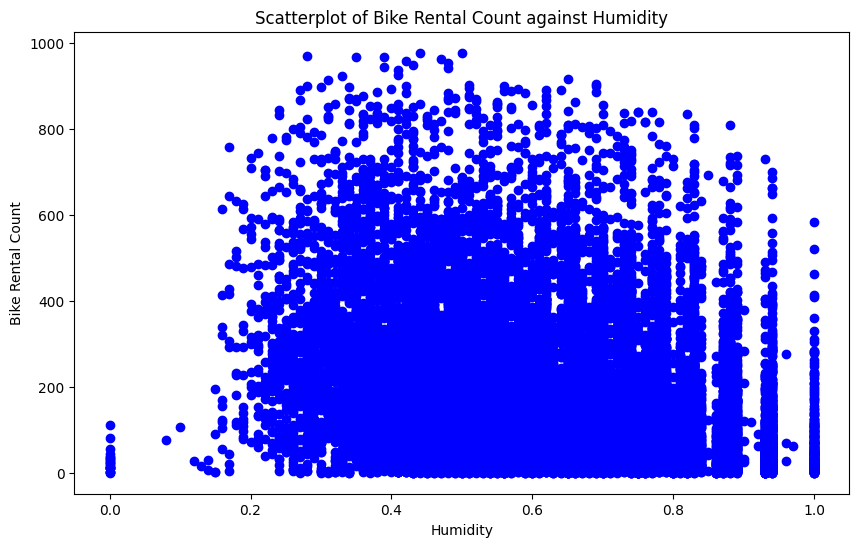

In [30]:
plt.figure(figsize=(10,6))
plt.scatter(df["hum"], df["cnt"], color="blue")
plt.title("Scatterplot of Bike Rental Count against Humidity")
plt.xlabel("Humidity")
plt.ylabel("Bike Rental Count")
plt.show()

Next, we investigate the relationship between the Number of Bike Rental Counts and the Seasons. The violinplot shows the distribution of the Bike Rental Counts for each season, and we can observe that the median for the number of Bike Rentals increase for the hotter seasons such as Spring and Summer. This relationship is made more clear after removing the outliers from the plot, as shown in the boxplot on the right.

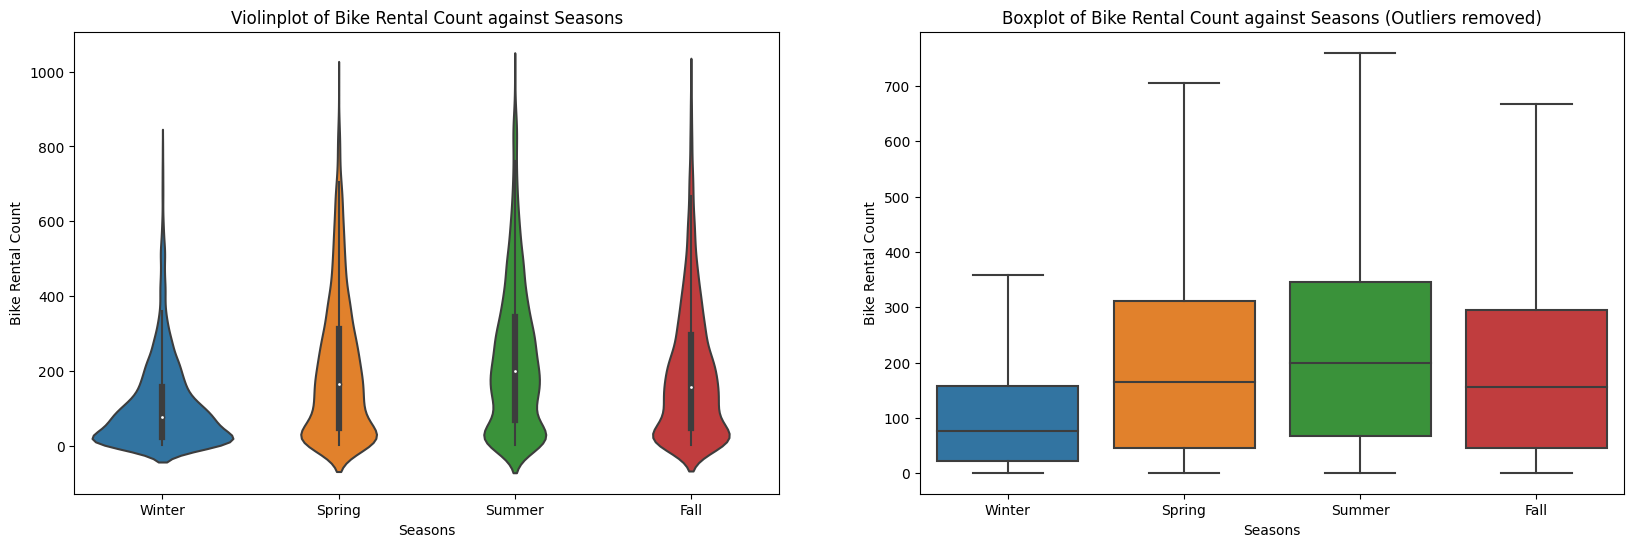

In [31]:
fig, axes = plt.subplots(1, 2, figsize = (20, 6))

sns.violinplot(x = 'season', y = 'cnt', data = df, ax = axes[0])
axes[0].set_xticks(np.arange(0, 4), ['Winter', 'Spring', 'Summer', 'Fall'])
axes[0].set_title('Violinplot of Bike Rental Count against Seasons')
axes[0].set_xlabel('Seasons')
axes[0].set_ylabel('Bike Rental Count')

sns.boxplot(x = 'season', y = 'cnt', data = df, ax = axes[1], showfliers=False)
axes[1].set_xticks(np.arange(0, 4), ['Winter', 'Spring', 'Summer', 'Fall'])
axes[1].set_title('Boxplot of Bike Rental Count against Seasons (Outliers removed)')
axes[1].set_xlabel('Seasons')
axes[1].set_ylabel('Bike Rental Count')
plt.show()

A similar process is performed to investigate the relationship between Rental Bike Counts and Weather. In this respect, it can be observed that a clear weather would likely correlate with higher Bike Rentals.

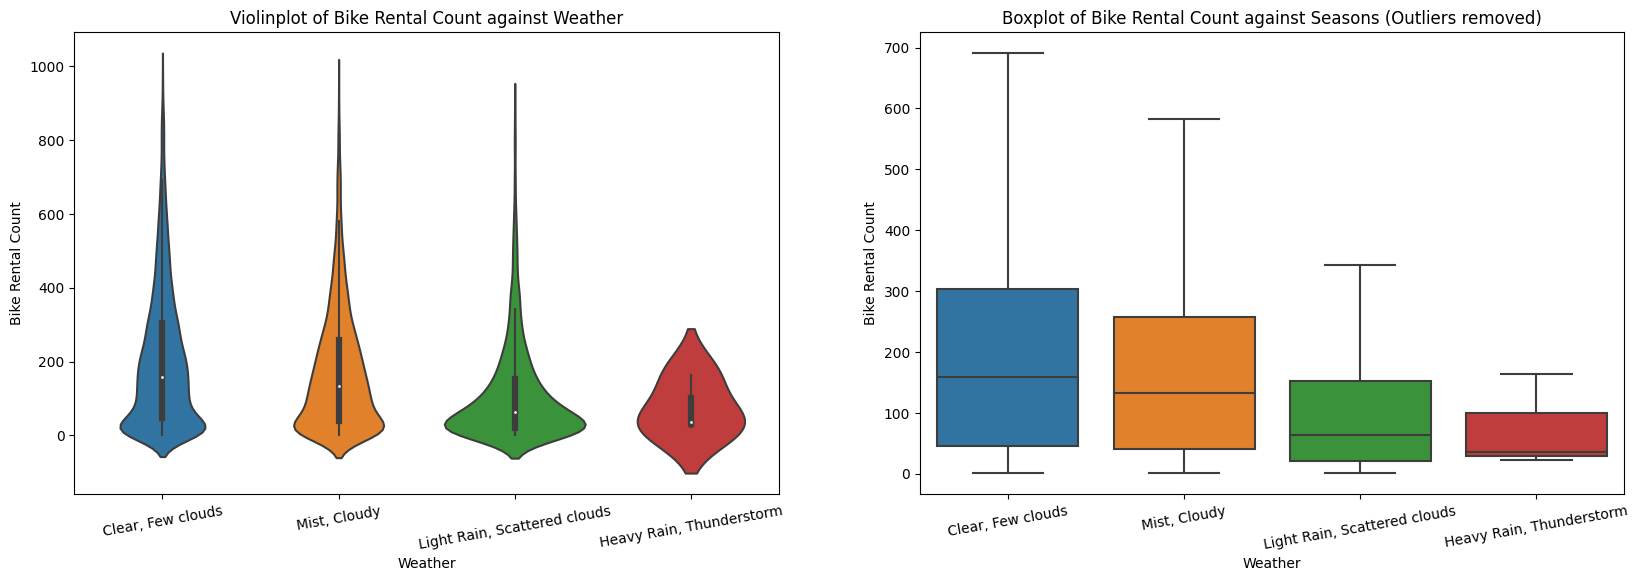

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (20, 6))

sns.violinplot(x = 'weathersit', y = 'cnt', data = df, ax = axes[0])
axes[0].set_xticks(np.arange(0, 4), ['Clear, Few clouds', 'Mist, Cloudy', 'Light Rain, Scattered clouds', 'Heavy Rain, Thunderstorm'], rotation = 10)
axes[0].set_title('Violinplot of Bike Rental Count against Weather')
axes[0].set_xlabel('Weather')
axes[0].set_ylabel('Bike Rental Count')

sns.boxplot(x = 'weathersit', y = 'cnt', data = df, ax = axes[1], showfliers=False)
axes[1].set_xticks(np.arange(0, 4), ['Clear, Few clouds', 'Mist, Cloudy', 'Light Rain, Scattered clouds', 'Heavy Rain, Thunderstorm'], rotation=10)
axes[1].set_title('Boxplot of Bike Rental Count against Seasons (Outliers removed)')
axes[1].set_xlabel('Weather')
axes[1].set_ylabel('Bike Rental Count')

plt.show()

Last, but certainly not least, we need to observe the distribution of the Response Variable, Bike Rental Counts. This can allow us to ascertain whether further data cleaning is required on the Response Variable.

I made use of Sturge's Rule to calculate the optimal bin size for the histogram, which gives us quite a nice right-half of the Gaussian Distribution.

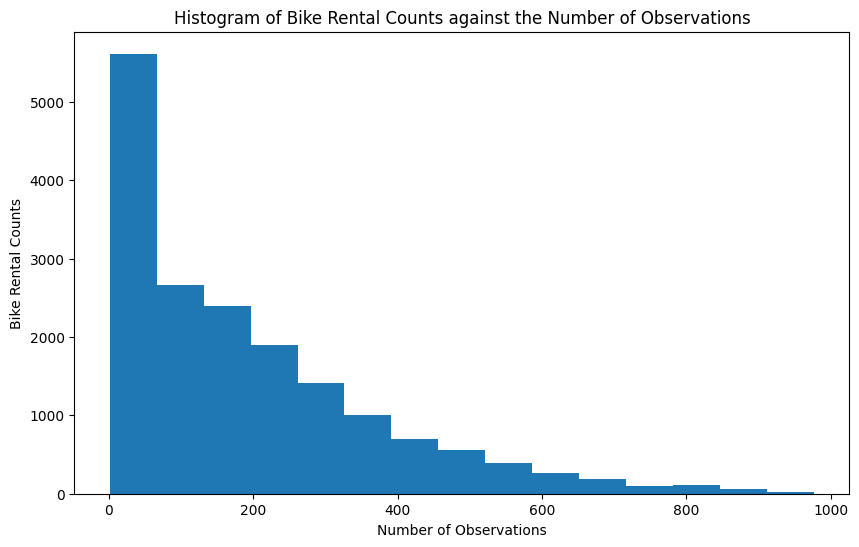

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(df["cnt"], bins=15)
plt.title("Histogram of Bike Rental Counts against the Number of Observations")
plt.xlabel('Number of Observations')
plt.ylabel('Bike Rental Counts')
plt.show()

Lastly, in order to investigate the prescence of outliers in the Bike Rental Counts, I made use of a Boxplot. There seems to be quite a large number of 'outliers', and I shall further investigate the nature of these outliers, to determine whether they should be removed, or it contains important information that should be used when fitting the ML Model.

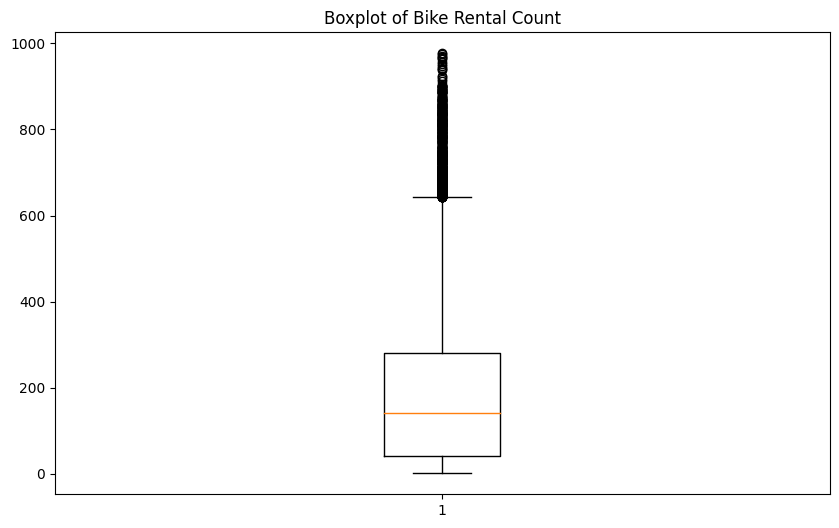

In [34]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['cnt'])
plt.title("Boxplot of Bike Rental Count")
plt.show()

Identify Outliers using the IQR method: This method is chosen, because albeit there are a large number of points and the Distribution seems to be Gaussian in nature, it is heavily right skewed. As such, the calculation for mean and standard deviation will likely not be accurate. This problem does not exist when using IQR.

In [35]:
#Z-score
z_scores = zscore(df['cnt'])
abs_z_scores = np.abs(z_scores)
outliers_zscore = (abs_z_scores > 3)

# IQR Method
Q1 = df['cnt'].quantile(0.25)
Q3 = df['cnt'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (df['cnt'] < (Q1 - 1.5 * IQR)) | (df['cnt'] > (Q3 + 1.5 * IQR))

# print("Outliers based on Z-Score:")
# print(df[outliers_zscore])
# print("\nOutliers based on IQR:")
# print(df[outliers_iqr])

iqr_outliers = df[outliers_iqr]
iqr_outliers.describe()


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.00000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,2.877228,0.998020,7.356436,14.508911,0.003960,3.20198,0.819802,1.245545,0.641901,0.602913,0.520851,0.206094,111.110891,638.132673,749.243564
std,0.840904,0.044499,2.385406,4.083020,0.062869,1.73514,0.384733,0.482948,0.129533,0.112182,0.172839,0.117278,86.178821,125.979560,80.900280
min,1.000000,0.000000,3.000000,8.000000,0.000000,0.00000,0.000000,1.000000,0.200000,0.212100,0.170000,0.000000,9.000000,288.000000,643.000000
25%,2.000000,1.000000,6.000000,8.000000,0.000000,2.00000,1.000000,1.000000,0.560000,0.530300,0.380000,0.134300,48.000000,594.000000,681.000000
50%,3.000000,1.000000,8.000000,17.000000,0.000000,3.00000,1.000000,1.000000,0.660000,0.621200,0.510000,0.194000,89.000000,662.000000,730.000000
75%,4.000000,1.000000,9.000000,18.000000,0.000000,5.00000,1.000000,1.000000,0.740000,0.666700,0.650000,0.283600,120.000000,727.000000,812.000000
max,4.000000,1.000000,12.000000,19.000000,1.000000,6.00000,1.000000,3.000000,0.920000,0.878800,0.940000,0.582100,367.000000,886.000000,977.000000


However, upon conducting further analysis on the outlier data, I realised that a majority of this data came from the year 2012. As mentioned previously, this could be due to the general upward trend in the number of Bike Rentals, as compared to it being erroneous outliers. As such, I decided not to omit these outliers as part of the Data Cleaning phase.

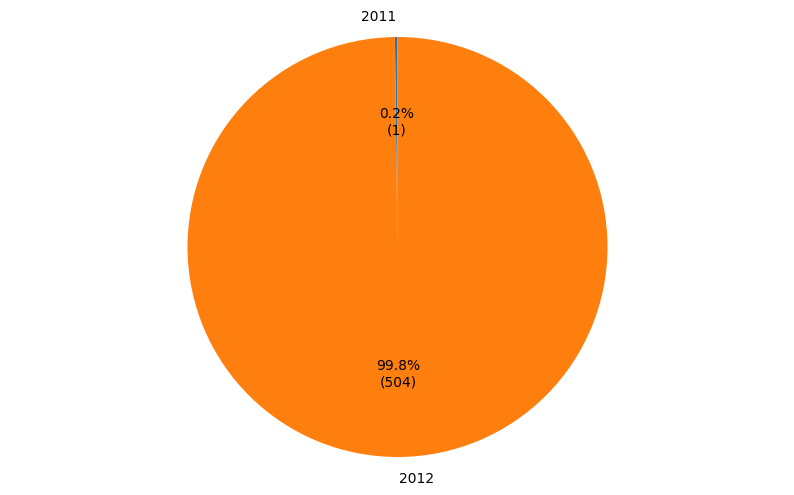

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.00000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,2.877228,0.998020,7.356436,14.508911,0.003960,3.20198,0.819802,1.245545,0.641901,0.602913,0.520851,0.206094,111.110891,638.132673,749.243564
std,0.840904,0.044499,2.385406,4.083020,0.062869,1.73514,0.384733,0.482948,0.129533,0.112182,0.172839,0.117278,86.178821,125.979560,80.900280
min,1.000000,0.000000,3.000000,8.000000,0.000000,0.00000,0.000000,1.000000,0.200000,0.212100,0.170000,0.000000,9.000000,288.000000,643.000000
25%,2.000000,1.000000,6.000000,8.000000,0.000000,2.00000,1.000000,1.000000,0.560000,0.530300,0.380000,0.134300,48.000000,594.000000,681.000000
50%,3.000000,1.000000,8.000000,17.000000,0.000000,3.00000,1.000000,1.000000,0.660000,0.621200,0.510000,0.194000,89.000000,662.000000,730.000000
75%,4.000000,1.000000,9.000000,18.000000,0.000000,5.00000,1.000000,1.000000,0.740000,0.666700,0.650000,0.283600,120.000000,727.000000,812.000000
max,4.000000,1.000000,12.000000,19.000000,1.000000,6.00000,1.000000,3.000000,0.920000,0.878800,0.940000,0.582100,367.000000,886.000000,977.000000


In [36]:
plt.figure(figsize=(10, 6))
grouped = iqr_outliers.groupby('yr').size()
# Function to format label with counts and percentages
def func(pct, allvals):
    absolute = round(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Plotting the pie chart
plt.pie(grouped, labels=['2011', '2012'], autopct=lambda pct: func(pct, grouped), startangle=90)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
iqr_outliers.describe()

Next, let's look at the correlation matrix, to decide what are the features that are related to each other to decide whether to remove/include certain features. From the correlation matrix, we can identify the features that are highly correlated to each other. First of all, `casual` and `registered` seem to be highly correlated to `cnt`. This makes sense because these casual and registered users directly contribute to the Bike Rental counts. As such, we need to remove these features before performing model fitting. In addition, we can see that `temp` and `atemp` are highly correlated to each other. This certainly makes sense. As mentioned previously, atemp is simply the 'Feels Like' temperature that has to be based on the real temperature at that time. As such, we should only choose to include 1 of these features, since including both would be redundant. Similarly, `season` is highly related to `mnth` for similar reasons, and thus we shall remove 1 of these 2 features.

/var/folders/dh/77csj5hj70b305yqt5ym43vh0000gn/T/ipykernel_42453/1523200020.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


<AxesSubplot: >

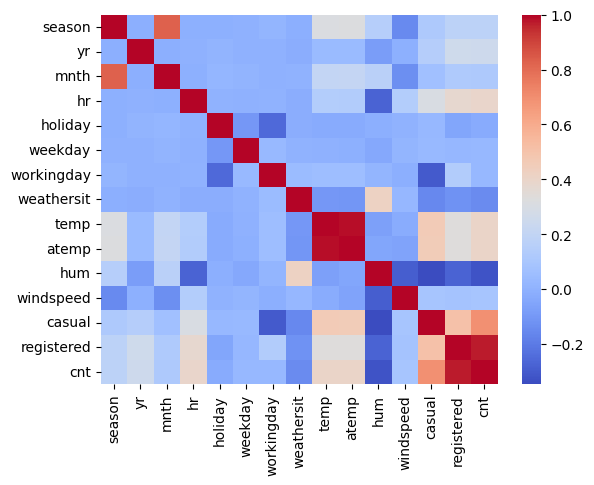

In [37]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')

### Chapter 2.3: Data-cleaning and Preprocessing

For the next stage, we will then use this understanding to perform data pre-processing, so that we can use the cleaned data to train our ML Model.

Let's start by removing irrelevant features. Based on my conclusion above, I have decided to remove `atemp`, `casual`, `season` and `registered` from the dataframe.

In [38]:
df.drop(labels = ['atemp', 'casual', 'registered', 'season'], axis = 1, inplace=True)
df.describe()

,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.627229,0.190098,189.463088
std,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.192930,0.122340,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.480000,0.104500,40.000000
50%,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.630000,0.194000,142.000000
75%,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.780000,0.253700,281.000000
max,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,0.850700,977.000000


Manipulation of categorical data: During our EDA Stage, we encountered some variables that were categorical in nature, but was represented numerically. Some examples of this were `season`, `weatheris`, `mnth`, `weekday`. These variables should no have innate ordering as they are independent from each other. Hence, I will perform One Hot Encoding on these features.

In [39]:
df_encoded = pd.get_dummies(df, columns = ["weathersit","mnth","weekday"],drop_first=True)
df_encoded


,dteday,yr,hr,holiday,workingday,temp,hum,windspeed,cnt,type_of_day,...,mnth_9,mnth_10,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01,0,0,0,0,0.24,0.81,0.0000,16,Weekend,...,0,0,0,0,0,0,0,0,0,1
1,2011-01-01,0,1,0,0,0.22,0.80,0.0000,40,Weekend,...,0,0,0,0,0,0,0,0,0,1
2,2011-01-01,0,2,0,0,0.22,0.80,0.0000,32,Weekend,...,0,0,0,0,0,0,0,0,0,1
3,2011-01-01,0,3,0,0,0.24,0.75,0.0000,13,Weekend,...,0,0,0,0,0,0,0,0,0,1
4,2011-01-01,0,4,0,0,0.24,0.75,0.0000,1,Weekend,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,1,19,0,1,0.26,0.60,0.1642,119,Working Day,...,0,0,0,1,1,0,0,0,0,0
17375,2012-12-31,1,20,0,1,0.26,0.60,0.1642,89,Working Day,...,0,0,0,1,1,0,0,0,0,0
17376,2012-12-31,1,21,0,1,0.26,0.60,0.1642,90,Working Day,...,0,0,0,1,1,0,0,0,0,0
17377,2012-12-31,1,22,0,1,0.26,0.56,0.1343,61,Working Day,...,0,0,0,1,1,0,0,0,0,0


In order to unlock the full potential of our time-series data, we should create 'lag' variables in order to incorporate the previous time data for each data point. This could give the ML model a higher predictive power, and achieve more accurate results.

In [40]:
df_encoded["cnt_lag_1"] = df_encoded["cnt"].shift(-1)
df_encoded["cnt_lag_2"] = df_encoded["cnt"].shift(-2)
df_encoded_include_lag = df_encoded.dropna()

Now, finally we are ready to conduct the test. I performed a train-test split of the time-series data across the date '2012-12-01'. The reason for doing so is because this data set is a time-series data, and hence it is important for time periods to be intact, and so we cannot randomly sample different points across the entire time period. After performing this step, we now have our X_train, X_test, y_train, y_test.

In [41]:
features = list(df_encoded_include_lag.columns)
features.remove('cnt')
features.remove('dteday')
features.remove('type_of_day')
target = ['cnt']
train_data = df_encoded_include_lag[df_encoded_include_lag['dteday'] < '2012-12-01'].reset_index(drop=True)
test_data = df_encoded_include_lag[df_encoded_include_lag['dteday'] >= '2012-12-01'].reset_index(drop=True)
X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

## Chapter 3: Model Training and Testing

Finally, after the data has been thoroughly cleaned and pre-processed, we can proceed on to the training and testing phase of the project. Here, we will explore fitting a few ML Models to see which performs the best. Afterwards, we test the performance of these models on our test set by choosing a suitable metric to evaluate our model. After which, we can perform hyperparameter tuning to optimise the performance of our model.

### Chapter 3.1: Training Phase

I have decided to make use of `RandomForestRegressor` from `sklearn` as the primary model to train. The `RandomForestRegressor` is an ensemble model making use of multiple decision trees to make a prediction of the data.

In [42]:
rf = RandomForestRegressor()
y_train = np.ravel(y_train)
rf.fit(X_train, y_train)

RandomForestRegressor()

### Chapter 3.2: Testing Phase

We now have a trained model. We can then make use of this model to test against our test data set, and subsequently evaluate the model using our chosen evaluation metric.

In [43]:
y_pred = rf.predict(X_test)


In [44]:
rmsle = np.sqrt(mean_squared_log_error(y_pred, y_test))
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
metric_df = pd.DataFrame(data = [[rmsle, rmse, mse, mae]], columns = ['rmsle', 'rmse', 'mse', 'mae'])
metric_df

,rmsle,rmse,mse,mae
0,0.320066,33.850981,1145.8889,20.964838


### Chapter 3.3: Hyperparameter Tuning

Now we can perform hyperparameter tuning on the data, as well as compare between 2 models: HistGradientBoostingRegressor and RandomForestRegressor, which are both powerful models to be used for Regression purposes.

In [32]:
# Be careful when running this cell. Estimated Runtime: 3h15mins on Google Colaboratory

models = {
    "Random Forest": RandomForestRegressor(
        random_state=42
    ),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        random_state=42
    ),
}
param_grids = {
    "Random Forest": {
        "n_estimators": [10, 20, 50, 100, 200],
        "max_depth": [None, 3,5,7,9],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1,2,4],
        },
    "Hist Gradient Boosting": {
        "max_iter": [10, 20, 50, 100, 300, 500],
        "max_depth": [None, 3,5,7,9],
        "learning_rate": [0.0001, 0.001, 0.01, 0.1],
        "max_leaf_nodes": [10, 20, 31, 50,100],
        "min_samples_leaf": [10,20,50, 100]
        },
}
tscv = TimeSeriesSplit(n_splits=5)

results = []
grid_search_results = {
    "Random Forest": None,
    "Hist Gradient Boosting": None
}
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=tscv,
    ).fit(X_train, y_train)
    grid_search_results[name] = grid_search
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

results

In [33]:
results[0]['cv_results'].to_csv("rf_grid.csv", index=False)
results[1]['cv_results'].to_csv("hgb_grid.csv", index=False)

In [34]:
grid_search_results['Random Forest'].best_params_

In [35]:
grid_search_results['Hist Gradient Boosting'].best_params_

### Chapter 3.4: Model Evaluation and Selection
Now that we have our optimised RandomForestRegressor and HistGradientBoostingRegressor parameters, we can use these parameters to train the respective models, to see which model provides a better performance.

In [45]:
import time

rf = RandomForestRegressor(n_estimators = 200)
hgb = HistGradientBoostingRegressor(max_iter=300, max_leaf_nodes=10, min_samples_leaf=10)

rf_start = time.time()
rf.fit(X_train, y_train)
rf_end = time.time()
hgb.fit(X_train, y_train)
hgb_end = time.time()

print(f"Fit time for RF is: {rf_end - rf_start} seconds")
print(f"Fit time for HGB is: {hgb_end - rf_end} seconds")

rf_start = time.time()
rf_y_pred = rf.predict(X_test)
rf_end = time.time()
hgb_y_pred = hgb.predict(X_test)
hgb_end = time.time()
hgb_y_pred = [max(0, pred) for pred in hgb_y_pred]

print(f"Predict time for RF is: {rf_end - rf_start} seconds")
print(f"Predict time for HGB is: {hgb_end - rf_end} seconds")

Fit time for RF is: 16.957039833068848 seconds
Fit time for HGB is: 2.66292405128479 seconds
Predict time for RF is: 0.20972800254821777 seconds
Predict time for HGB is: 0.04281187057495117 seconds


In [46]:
rf_rmsle = np.sqrt(mean_squared_log_error(rf_y_pred, y_test))
rf_rmse = np.sqrt(mean_squared_error(rf_y_pred, y_test))
rf_mse = mean_squared_error(rf_y_pred, y_test)
rf_mae = mean_absolute_error(rf_y_pred, y_test)

hgb_rmsle = np.sqrt(mean_squared_log_error(hgb_y_pred, y_test))
hgb_rmse = np.sqrt(mean_squared_error(hgb_y_pred, y_test))
hgb_mse = mean_squared_error(hgb_y_pred, y_test)
hgb_mae = mean_absolute_error(hgb_y_pred, y_test)

metric_df = pd.DataFrame(data = [[rf_rmsle, rf_rmse, rf_mse, rf_mae], [hgb_rmsle, hgb_rmse, hgb_mse, hgb_mae]], columns = ['rf_rmsle', 'rf_rmse', 'rf_mse', 'rf_mae'], index = ['RandomForest', 'HistGradientBoosting'])
metric_df

,rf_rmsle,rf_rmse,rf_mse,rf_mae
RandomForest,0.319157,34.037201,1158.531073,21.045500
HistGradientBoosting,0.400249,35.564107,1264.805737,23.370058


Upon Analysing the different performances between the 2 models, we can notice that the RandomForest Regressor consistently performs better across all 4 metrics, albeit the fit time is higher on average compared to the HistGradientBoosting Regressor. Given that I believe this additional time trade-off is potentially worth it to obtain higher quality predictions, and the lack of negative value predictions made by RandomForestRegressor compared to a small number made by HistGradientBoostingRegressor, I would select RandomForestRegressor as the more appropriate model.

To conclude the project, let us visualise the performance of our models at predicting the data, compared to the actual observed values.

Text(0.5, 0, 'Datetime')

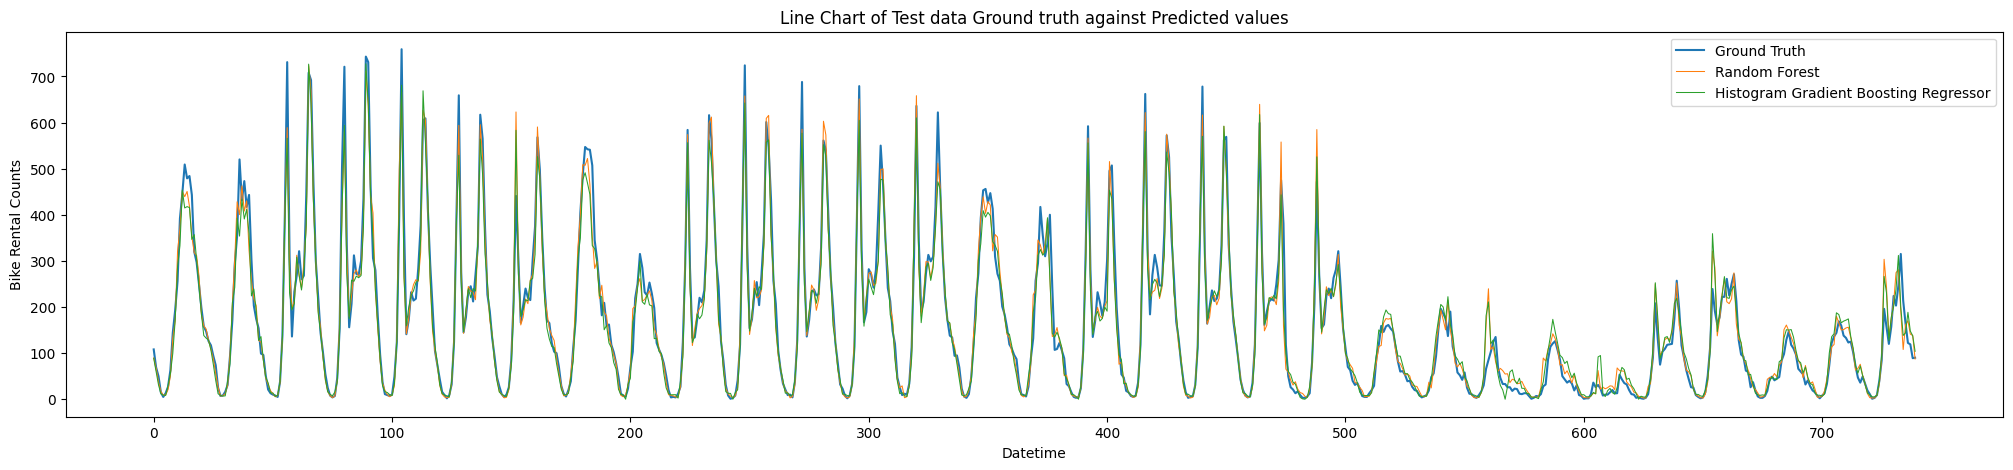

In [47]:
plt.figure(figsize=(25, 5))
plt.plot(y_test)
plt.plot(rf_y_pred, linewidth=0.75)
plt.plot(hgb_y_pred, linewidth=0.75)
plt.legend(loc="best", labels=["Ground Truth", "Random Forest", "Histogram Gradient Boosting Regressor"])
plt.title("Line Chart of Test data Ground truth against Predicted values")
plt.ylabel("Bike Rental Counts")
plt.xlabel("Datetime")

Export the model

In [48]:
from joblib import dump

# Save the model to a file
dump(rf, 'rf.pkl')

['rf.pkl']

## Chapter 4: Extras

Create a model that does not contain lag_variables

In [51]:
no_lag_features = features.copy()
no_lag_features.remove('cnt_lag_1')
no_lag_features.remove('cnt_lag_2')


['yr',
 'hr',
 'holiday',
 'workingday',
 'temp',
 'hum',
 'windspeed',
 'weathersit_2',
 'weathersit_3',
 'weathersit_4',
 'mnth_2',
 'mnth_3',
 'mnth_4',
 'mnth_5',
 'mnth_6',
 'mnth_7',
 'mnth_8',
 'mnth_9',
 'mnth_10',
 'mnth_11',
 'mnth_12',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'cnt_lag_1',
 'cnt_lag_2']

In [55]:
X_train, y_train = train_data[no_lag_features], train_data[target]
X_test, y_test = test_data[no_lag_features], test_data[target]
rf_no_lag = RandomForestRegressor(n_estimators = 200)
y_train = np.ravel(y_train)
rf_no_lag.fit(X_train, y_train)
no_lag_rf_pred = rf_no_lag.predict(X_test)

Text(0.5, 0, 'Datetime')

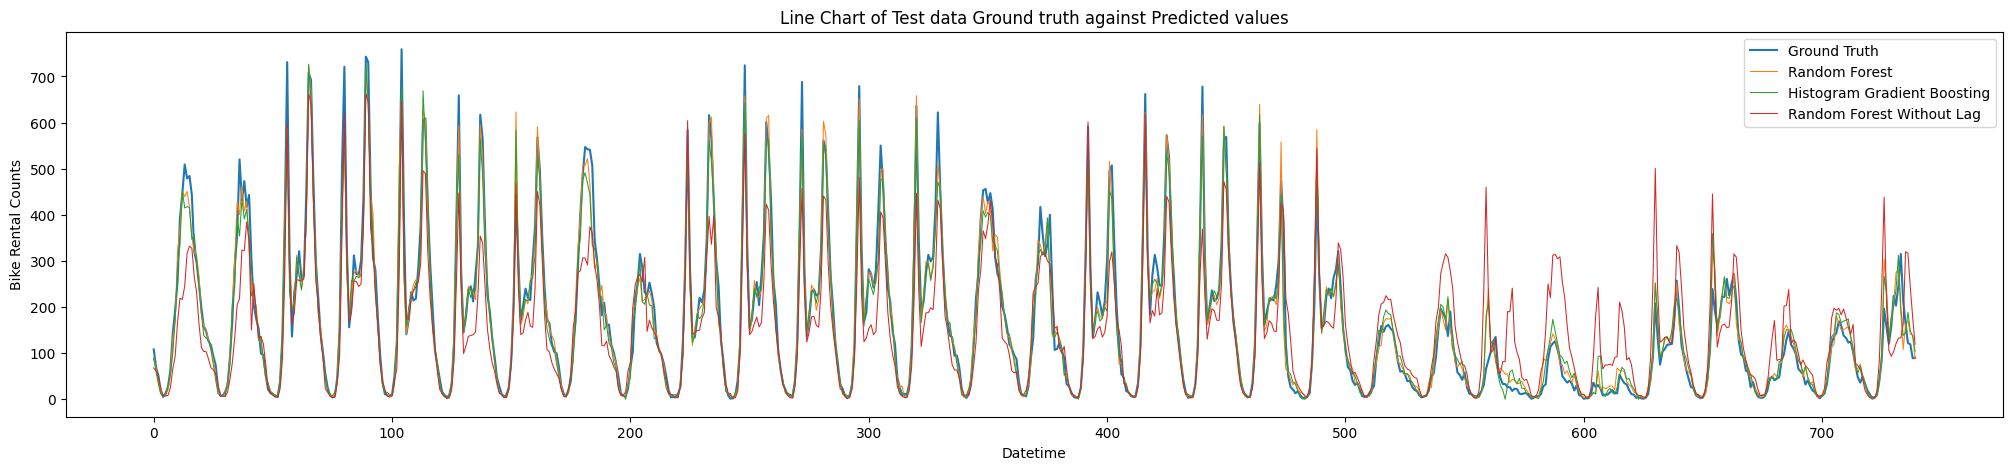

In [57]:
plt.figure(figsize=(25, 5))
plt.plot(y_test)
plt.plot(rf_y_pred, linewidth=0.75)
plt.plot(hgb_y_pred, linewidth=0.75)
plt.plot(no_lag_rf_pred, linewidth=0.75)
plt.legend(loc="best", labels=["Ground Truth", "Random Forest", "Histogram Gradient Boosting", "Random Forest Without Lag"])
plt.title("Line Chart of Test data Ground truth against Predicted values")
plt.ylabel("Bike Rental Counts")
plt.xlabel("Datetime")

In [58]:
dump(rf_no_lag, 'no_lag_rf.pkl')

['no_lag_rf.pkl']

In [66]:
df.groupby('weathersit').describe()

yr                                                  mnth  \
              count      mean       std  min  25%  50%  75%  max    count   
weathersit                                                                  
1           11413.0  0.505389  0.499993  0.0  0.0  1.0  1.0  1.0  11413.0   
2            4544.0  0.511884  0.499914  0.0  0.0  1.0  1.0  1.0   4544.0   
3            1419.0  0.449612  0.497630  0.0  0.0  0.0  1.0  1.0   1419.0   
4               3.0  0.666667  0.577350  0.0  0.5  1.0  1.0  1.0      3.0   

                      ... windspeed              cnt                          \
                mean  ...       75%     max    count        mean         std   
weathersit            ...                                                      
1           6.511872  ...    0.2537  0.8060  11413.0  204.869272  189.487773   
2           6.618838  ...    0.2537  0.7164   4544.0  175.165493  165.431589   
3           6.498238  ...    0.2985  0.8507   1419.0  111.579281  133.781045   
4           1.000000  ...    0.2612  0.3284      3.0   74.333333   77.925178   

                                             
             min   25%    50%    75%    max  
weathersit                                   
1            1.0  46.0  159.0  304.0  977.0  
2            1.0  40.0  133.0  257.0  957.0  
3            1.0  21.0   63.0  152.5  891.0  
4           23.0  29.5   36.0  100.0  164.0  

[4 rows x 80 columns]